In [1]:
!pip install mxnet-cu100

#MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

mx.random.seed(1)

model_ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.FashionMNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.FashionMNIST(train = False, transform = transform)

In [4]:
image, label = train_mnist[0]
print(image.shape, label.shape)

(28, 28, 1) ()


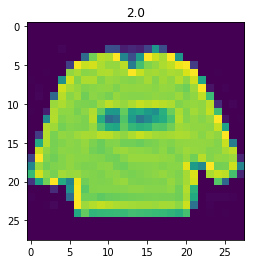

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.title(label)
plt.show()


##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

##Building the model

In [0]:
weight_scale = .01

#  Allocate parameters for the first hidden layer
W1 = nd.random_normal(shape = (784, 256), scale=weight_scale, ctx=model_ctx)
b1 = nd.random_normal(shape = 256, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the second hidden layer
W2 = nd.random_normal(shape = (256, 128), scale=weight_scale, ctx=model_ctx)
b2 = nd.random_normal(shape = 128, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the output layer
W3 = nd.random_normal(shape=(128, 10), scale=weight_scale, ctx=model_ctx)
b3 = nd.random_normal(shape=10, scale=weight_scale, ctx=model_ctx)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()
    
def neuralnetworks(inputs):
    layer1 = nd.relu(nd.dot(inputs, W1) + b1)
    layer2 = nd.relu(nd.dot(layer1, W2) + b2)
    return nd.softmax(nd.dot(layer2, W3) + b3)

##Defining our objective function

In [0]:
def categoricalcrossentropy(predictions, labels):
    return -nd.sum(labels * nd.log(predictions))

##Defining our parameters optimizer

In [0]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

##Defining our accuracy function

In [0]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

##Defining Different Types of Cyclic Based Decay

In [0]:
def triangular_cyclic_decay(lr, stepsize, max_lr, epoch):
    cycle = nd.floor(1 + epoch/(2 * stepsize))
    x = nd.abs(epoch/stepsize - 2 * cycle + 1)
    return lr + (max_lr - lr) * nd.maximum(0, (1 - x))

def triangular2_cyclic_decay(lr, stepsize, max_lr, epoch):
    cycle = nd.floor(1 + epoch/(2 * stepsize))
    x = nd.abs(epoch/stepsize - 2 * cycle + 1)
    return lr + (max_lr - lr) * nd.maximum(0, (1 - x))/(2**(cycle - 1))

def exp_range_cyclic_decay(lr, stepsize, max_lr, gamma, epoch):
    cycle = nd.floor(1 + epoch/(2 * stepsize))
    x = nd.abs(epoch/stepsize - 2 * cycle + 1)
    return lr + (max_lr - lr) * nd.maximum(0, (1 - x))*gamma**(epoch)

##Doing a quick visualization for different types of  cyclic decays

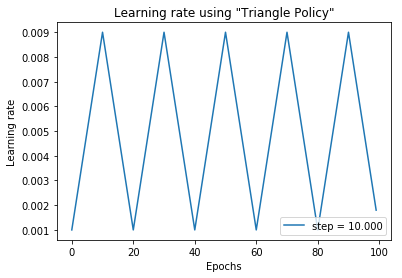

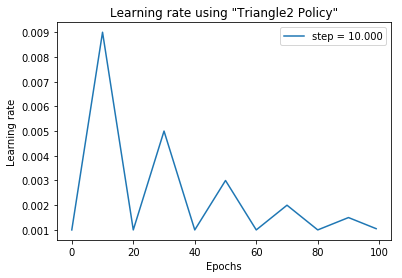

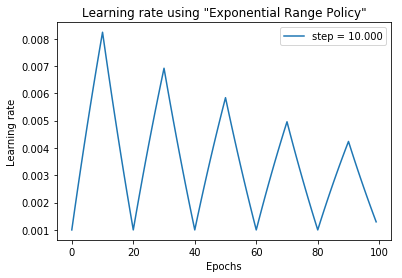

In [12]:
step = nd.array([10], ctx = model_ctx)
#step should be whole number

max_lr = 0.009

epochs = 100

lr = nd.array([0.001], ctx = model_ctx)

lrs = []
for epoch in range(epochs):
    lr_ = triangular_cyclic_decay(lr, step, max_lr, epoch)
    lrs.append(lr_.asscalar())

plt.plot(list(range(epochs)), lrs, label = f'step = {step.asscalar():.3f}')
plt.title('Learning rate using "Triangle Policy"')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend()
plt.show()

# =================================================

lrs = []
for epoch in range(epochs):
    lr_ = triangular2_cyclic_decay(lr, step, max_lr, epoch)
    lrs.append(lr_.asscalar())

plt.plot(list(range(epochs)), lrs, label = f'step = {step.asscalar():.3f}')
plt.title('Learning rate using "Triangle2 Policy"')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend()
plt.show()

# =================================================

gamma = 0.99
lrs = []
for epoch in range(epochs):
    lr_ = exp_range_cyclic_decay(lr, step, max_lr, gamma, epoch)
    lrs.append(lr_.asscalar())

plt.plot(list(range(epochs)), lrs, label = f'step = {step.asscalar():.3f}')
plt.title('Learning rate using "Exponential Range Policy"')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend()
plt.show()

##Training the  model

In [13]:
epochs = 10
num_batches = 60000//batch_size

base_lr = nd.array([.0001], ctx = model_ctx)
max_lr = nd.array([.005], ctx = model_ctx)
step = nd.array([1], ctx = model_ctx)
gamma = 0.9

losses = []
accs = []
lrs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    
    # Lets see how exponential one performs
    learning_rate = exp_range_cyclic_decay(base_lr, step, max_lr, gamma, epoch)
    lrs.append(learning_rate.asscalar())
    
    for features, labels in training_data:
        features = features.as_in_context(model_ctx).reshape((-1, 784))
        labels = labels.as_in_context(model_ctx).one_hot(10)
        with autograd.record():
            output = neuralnetworks(features)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        
        sgd(params, learning_rate)
        
        cumulative_loss += loss
        acc = accuracy(output, labels)
        cumulative_acc += acc
        losses.append(loss.asscalar())
        accs.append(acc.asscalar())
    print(f'Epoch: {epoch} | Loss: {cumulative_loss.asscalar()/num_batches:.5f} | Accuracy: {cumulative_acc.asscalar()/num_batches:.5f} | Learning Rate: {learning_rate.asscalar():.10f}')

Epoch: 0 | Loss: 147.28930 | Accuracy: 0.17986 | Learning Rate: 0.0001000000
Epoch: 1 | Loss: 47.11476 | Accuracy: 0.72067 | Learning Rate: 0.0045099999
Epoch: 2 | Loss: 25.88126 | Accuracy: 0.85471 | Learning Rate: 0.0001000000
Epoch: 3 | Loss: 27.03623 | Accuracy: 0.84502 | Learning Rate: 0.0036720999
Epoch: 4 | Loss: 21.99934 | Accuracy: 0.87468 | Learning Rate: 0.0001000000
Epoch: 5 | Loss: 23.45500 | Accuracy: 0.86576 | Learning Rate: 0.0029934009
Epoch: 6 | Loss: 19.86374 | Accuracy: 0.88767 | Learning Rate: 0.0001000000
Epoch: 7 | Loss: 21.18742 | Accuracy: 0.87899 | Learning Rate: 0.0024436549
Epoch: 8 | Loss: 18.55186 | Accuracy: 0.89428 | Learning Rate: 0.0001000000
Epoch: 9 | Loss: 19.66225 | Accuracy: 0.88757 | Learning Rate: 0.0019983603


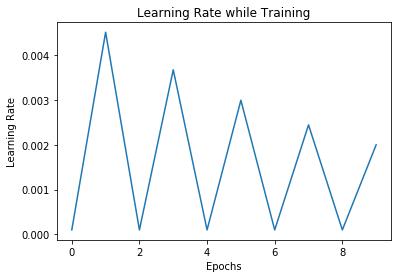

In [14]:
plt.plot(list(range(epochs)), lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate while Training')
plt.show()         

##Lets see test accuracy

In [15]:
acc = 0.0
batches = 0
for features, labels in testing_data:
    features = features.as_in_context(model_ctx).reshape((-1, 784))
    labels = labels.as_in_context(model_ctx).one_hot(10)
    predictions = neuralnetworks(features)
    acc += accuracy(predictions, labels)
    batches += 1
print(f'Test Accuracy: {acc.asscalar()/batches}')

Test Accuracy: 0.8835589171974523


In [0]:
def plot(losses = losses, accs = accs, model = neuralnetworks, samples = 5):
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    for i, batch in enumerate(test_mnist):
        features = batch[0].as_in_context(model_ctx).reshape((1, 784))
        labels = batch[1]
        predictions = model(features).argmax(1).asscalar()
        plt.imshow(features.reshape((28, 28)).asnumpy())
        plt.title(f'Predicted Class: {predictions}, Target Class: {labels}')
        plt.show()
        if i == samples:
            break

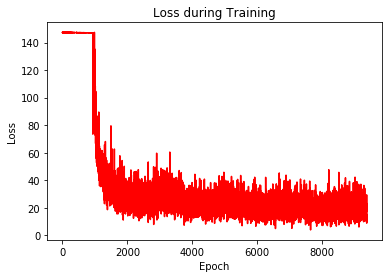

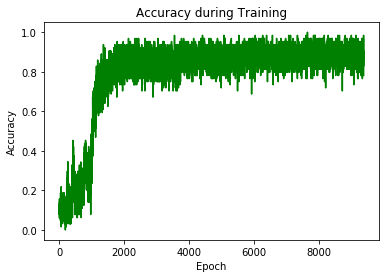

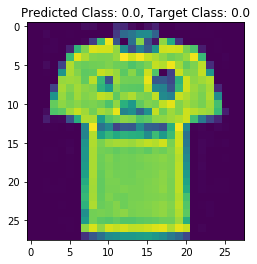

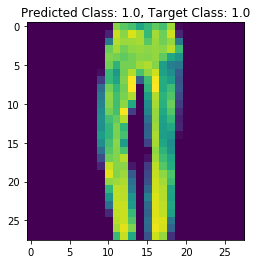

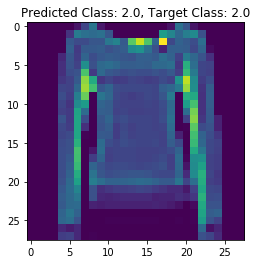

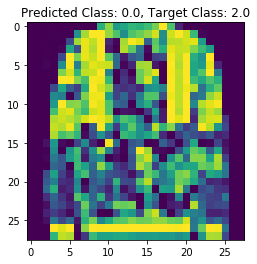

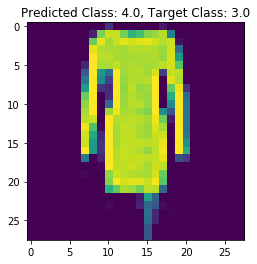

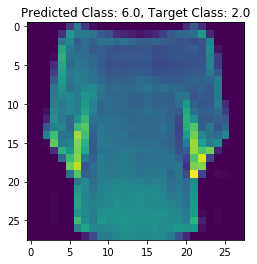

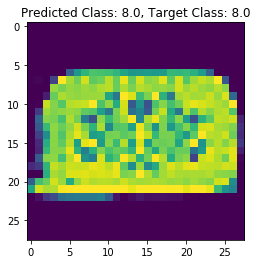

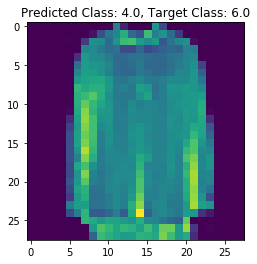

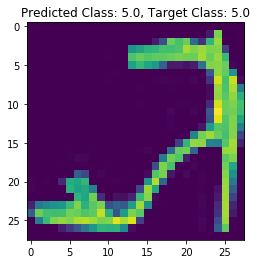

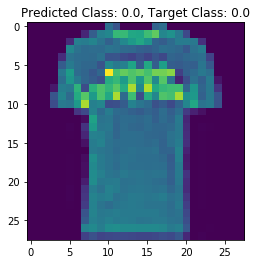

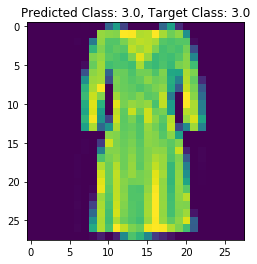

In [17]:
plot(samples = 10)